This is the second colab notebook of the GlyphGAN model that Henry and I made for our final of Allison's [Material of Language](https://mol.decontextualize.com/) class. It loads the font data set prepared in the first notebook (GlyphGAN_Preprocess_Fonts) and use it to train the GlyphGAN model.

The code is based on this repo: https://github.com/thunchakorn/ThaiFontGANs

# Getting Started
Here we define a set of variables to save and resume the model for training purpose, and mount google drive to save the models.

In [0]:
char_number = 30
img_size = 128
resume_iteration = 1330    # 0 means training from scratch
google_drive_model_folder_path = '/content/gdrive/My Drive/2020 Spring/Material of Language/MOL Final/GlyphGAN Trained Models/Calligraphy/'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Load Model
Then load the font data npy file from google drive, and define the generator, discriminator, and helper functions. 

In [0]:
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose, Reshape, Dropout
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = np.load(google_drive_model_folder_path + 'fontarray_calligraphy.npy')
data = data/255.0
data = data.reshape(-1,char_number,img_size,img_size,1)
data = data.transpose(1,0,2,3,4)

In [0]:
def make_generator():
  model = Sequential()
  model.add(Dense(8*8*512, input_dim = 128 + char_number))
  model.add(ReLU())
  
  model.add(Reshape((8,8,512)))
  model.add(Conv2DTranspose(512, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
            
  model.add(Conv2DTranspose(256, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
  
  model.add(Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same'))
  model.add(ReLU())
  
  model.add(Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', activation='sigmoid'))
            
  return model

In [0]:
def make_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(img_size,img_size,1)))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Flatten())
  model.add(Dense(1))
  return model

In [0]:
@tf.function
def gen_fake_image(z):
    image_sample = generator(z)
    return tf.cast(image_sample, dtype = tf.dtypes.float32)

In [0]:
@tf.function
def cal_gradient_penalty(real_data, z):
  fake_data = gen_fake_image(z)

  alpha = tf.random.uniform(
        shape=[BATCH_SIZE,1], 
        minval=0.,
        maxval=1.
    )

  differences = fake_data - real_data
  interpolates = real_data + tf.reshape((alpha*tf.reshape(differences, (BATCH_SIZE,-1))), (BATCH_SIZE, img_size, img_size, 1))
  gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
  slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = 1))
  gradient_penalty = tf.reduce_mean((slopes-1.)**2)
  return gradient_penalty

In [0]:
@tf.function
def cal_disc_cost(real_data, z, gradient_penalty):
  fake_data = gen_fake_image(z)
  return tf.reduce_mean(discriminator(fake_data)) - tf.reduce_mean(discriminator(real_data)) + LAMBDA*gradient_penalty

In [0]:
@tf.function
def make_one_hot(c, num, seed = None, num_char = char_number):
  return tf.concat([tf.reshape(tf.tile(tf.one_hot(c, num_char, dtype = tf.dtypes.float32), [num]), [-1, num_char]),
                    tf.random.normal(shape = (num,128), dtype = tf.dtypes.float32, seed = seed)], axis = 1)

In [0]:
@tf.function
def make_consist(num_char = char_number):
  z = tf.tile(tf.random.normal(shape = (1,128), dtype = tf.dtypes.float32), [num_char,1])
  letter_one_hot = tf.reshape(tf.one_hot(0, num_char, dtype = tf.dtypes.float32), [1,-1])
  for c in range(1, num_char):
    temp = tf.reshape(tf.one_hot(c, num_char, dtype = tf.dtypes.float32), [1, -1])
    letter_one_hot = tf.concat([letter_one_hot, temp], axis = 0)
  return tf.concat([letter_one_hot,z], axis = 1)

In [0]:
def update_disc(batch_data, c):
  real_data = tf.cast(batch_data, dtype = tf.float32)
  tf.random.set_seed(None)
  z = make_one_hot(c, BATCH_SIZE)

  with tf.GradientTape() as tape:
    gradient_penalty = cal_gradient_penalty(real_data, z)
    disc_cost = cal_disc_cost(real_data, z, gradient_penalty)
  disc_gradient = tape.gradient(disc_cost, discriminator.trainable_variables)
  disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
  return disc_cost

In [0]:
def update_gen(c):
    tf.random.set_seed(None)
    z = make_one_hot(c, BATCH_SIZE)
    with tf.GradientTape() as tape:
      fake_data = gen_fake_image(z)
      gen_cost = -tf.reduce_mean(discriminator(fake_data))
    gen_gradient = tape.gradient(gen_cost, generator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    return gen_cost

In [0]:
def plot_image(iteration, numchar = char_number):
    z = make_consist(num_char = numchar)
    fig = plt.figure(figsize=(9,6))
    image_sample = gen_fake_image(z)
    image_sample = image_sample.numpy().reshape(-1,img_size,img_size,1)
    for i in range(image_sample.shape[0]):
      plt.subplot(9, 6, i+1)
      plt.axis('off')
      plt.imshow(image_sample[i, :, :, 0], cmap = 'gray')
      plt.savefig('save_img/iteration{}.png'.format(iteration))
    plt.show()
    plt.close()
    
   
def plot_loss(disc_cost_epoch, gen_cost_epoch):
  fig, axes = plt.subplots(1,2, figsize = (16,4))
  axes[0].plot(disc_cost_epoch, label = 'discriminator loss', color = 'orange')
  axes[0].legend()
  
  axes[1].plot(gen_cost_epoch, label = 'generator loss', color = 'blue')
  axes[1].legend()
  plt.show()
  plt.clf()


def plot_same(z_fix, iteration):
    fig = plt.figure(figsize=(9,6))
    image_sample = gen_fake_image(z_fix)
    image_sample = image_sample.numpy().reshape(-1,img_size,img_size,1)
    for i in range(image_sample.shape[0]):
      plt.subplot(9, 6, i+1)
      plt.axis('off')
      plt.imshow(image_sample[i, :, :, 0], cmap = 'gray')
      plt.savefig('save_img_fix/iteration{}.png'.format(iteration))
    plt.show()
    plt.close()

In [0]:
disc_opt = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.5, 
        beta_2=0.99)

gen_opt = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.5, 
        beta_2=0.99)

A fixed latent vector *z_fix* is defined as a reference.

In [0]:
z_fix = make_consist(num_char = char_number)
np.save('z_fix.npy', z_fix.numpy())
z_fix = tf.constant(np.load('z_fix.npy'))

In [0]:
generator = make_generator()
discriminator = make_discriminator()

# Train the Model
Here we add a bunch of folders to save the model and the interim outputs during training. If this is not the first time to train the model, we'll also need to resume training by loading the weights first.

In [0]:
!mkdir checkpoint_gen
!mkdir checkpoint_disc
!mkdir save_img_fix
!mkdir save_img

In [0]:
if resume_iteration > 0:
  generator.load_weights('{}cp_gen_{}th_epoch.h5'.format(google_drive_model_folder_path, resume_iteration))
  discriminator.load_weights('{}cp_disc_{}_th_epoch.h5'.format(google_drive_model_folder_path, resume_iteration))

finish epoch:850 --- time use this epoch:64.10063600540161


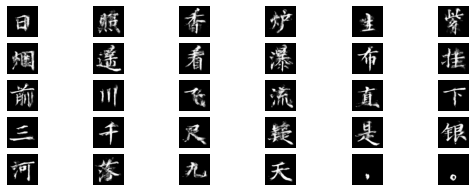

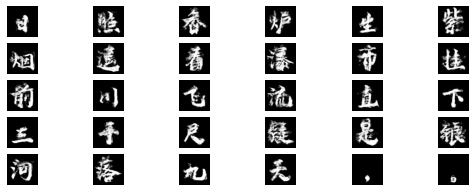

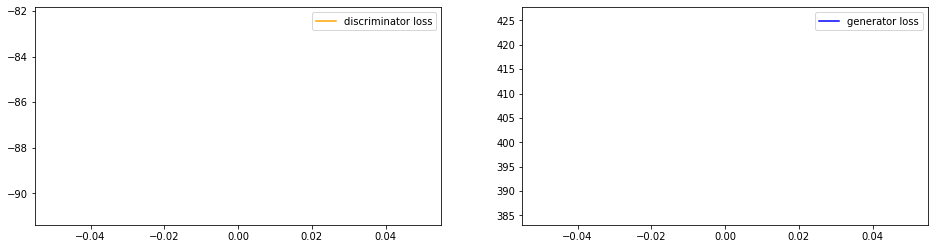

finish epoch:851 --- time use this epoch:63.896241903305054
finish epoch:852 --- time use this epoch:63.74468946456909
finish epoch:853 --- time use this epoch:64.08398079872131
finish epoch:854 --- time use this epoch:64.10831499099731
finish epoch:855 --- time use this epoch:64.1478853225708
finish epoch:856 --- time use this epoch:64.23729968070984
finish epoch:857 --- time use this epoch:63.84740114212036
finish epoch:858 --- time use this epoch:63.58228611946106
finish epoch:859 --- time use this epoch:63.893922328948975
finish epoch:860 --- time use this epoch:63.35145044326782


<Figure size 432x288 with 0 Axes>

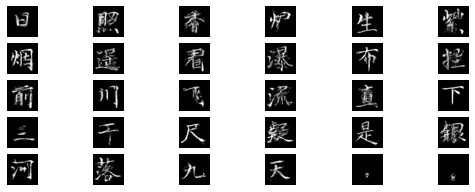

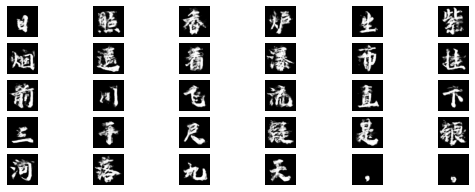

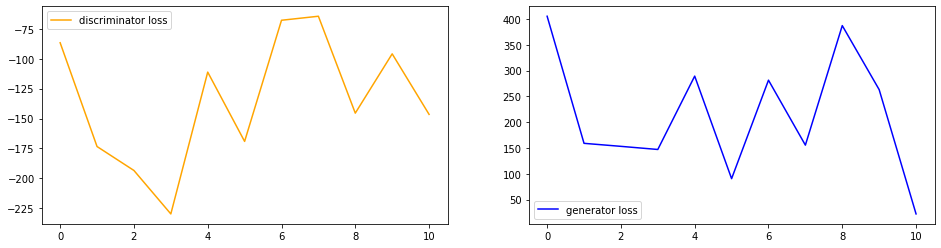

finish epoch:861 --- time use this epoch:64.3822968006134
finish epoch:862 --- time use this epoch:63.47305393218994
finish epoch:863 --- time use this epoch:63.371293783187866
finish epoch:864 --- time use this epoch:63.642714738845825
finish epoch:865 --- time use this epoch:63.3294997215271
finish epoch:866 --- time use this epoch:63.383960008621216
finish epoch:867 --- time use this epoch:63.64252758026123
finish epoch:868 --- time use this epoch:63.73915195465088
finish epoch:869 --- time use this epoch:63.6558792591095
finish epoch:870 --- time use this epoch:63.372036933898926


<Figure size 432x288 with 0 Axes>

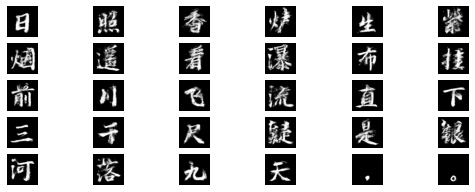

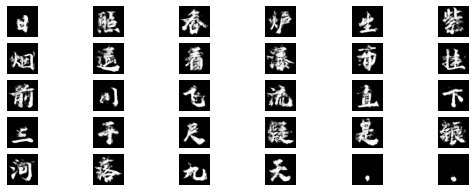

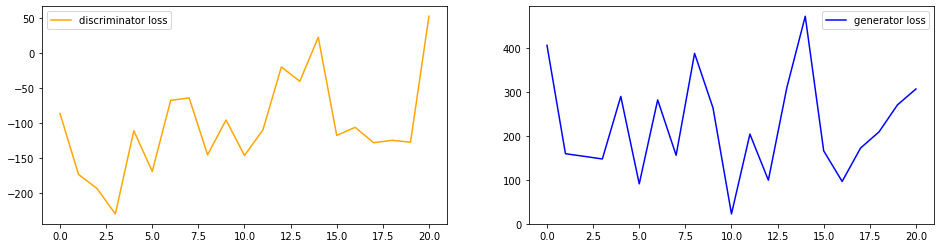

finish epoch:871 --- time use this epoch:63.94901132583618
finish epoch:872 --- time use this epoch:62.801265001297
finish epoch:873 --- time use this epoch:63.191250801086426
finish epoch:874 --- time use this epoch:62.88223195075989
finish epoch:875 --- time use this epoch:62.881099462509155
finish epoch:876 --- time use this epoch:63.27898716926575
finish epoch:877 --- time use this epoch:62.89478921890259
finish epoch:878 --- time use this epoch:63.135329246520996
finish epoch:879 --- time use this epoch:63.21273493766785
finish epoch:880 --- time use this epoch:63.37951421737671


<Figure size 432x288 with 0 Axes>

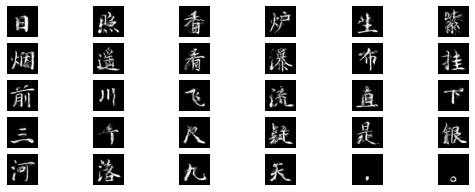

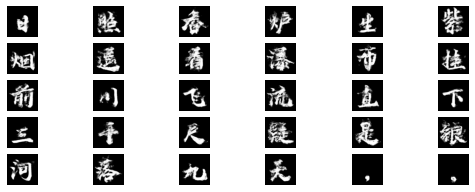

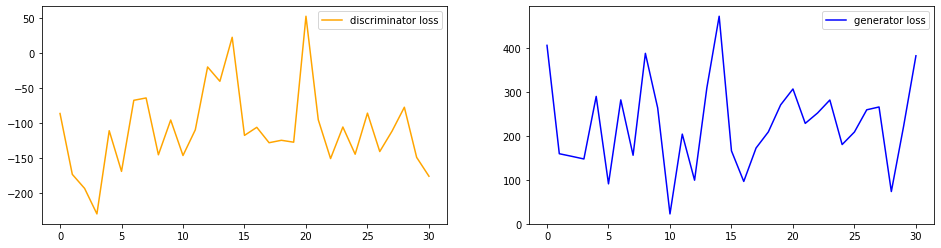

finish epoch:881 --- time use this epoch:64.13453793525696
finish epoch:882 --- time use this epoch:63.529314279556274
finish epoch:883 --- time use this epoch:63.74647879600525
finish epoch:884 --- time use this epoch:63.08629608154297
finish epoch:885 --- time use this epoch:63.320677280426025
finish epoch:886 --- time use this epoch:63.40476965904236
finish epoch:887 --- time use this epoch:63.339293479919434
finish epoch:888 --- time use this epoch:63.52726483345032
finish epoch:889 --- time use this epoch:63.405176401138306
finish epoch:890 --- time use this epoch:63.19166803359985


<Figure size 432x288 with 0 Axes>

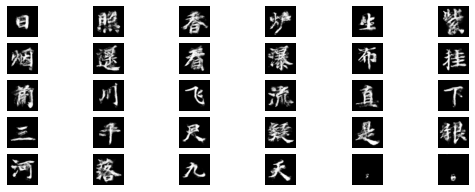

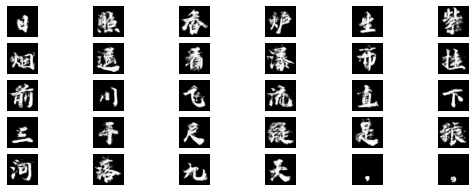

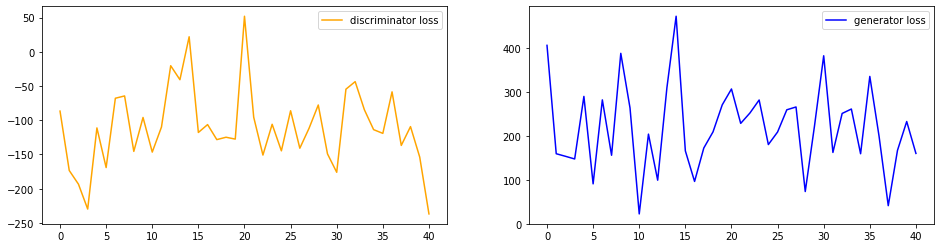

finish epoch:891 --- time use this epoch:65.49477052688599
finish epoch:892 --- time use this epoch:63.328447341918945
finish epoch:893 --- time use this epoch:63.592267990112305
finish epoch:894 --- time use this epoch:63.70229244232178
finish epoch:895 --- time use this epoch:63.33678150177002
finish epoch:896 --- time use this epoch:63.392772912979126
finish epoch:897 --- time use this epoch:63.543399810791016
finish epoch:898 --- time use this epoch:63.87241339683533
finish epoch:899 --- time use this epoch:63.508476972579956
finish epoch:900 --- time use this epoch:63.47627592086792


<Figure size 432x288 with 0 Axes>

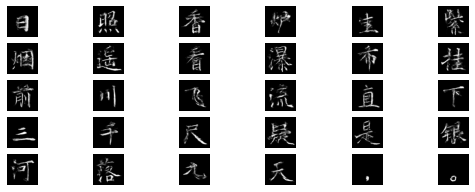

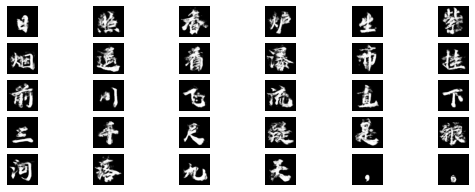

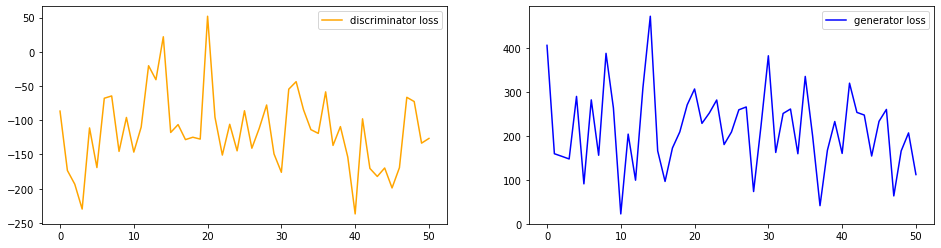

finish epoch:901 --- time use this epoch:64.25260615348816
finish epoch:902 --- time use this epoch:63.590506076812744
finish epoch:903 --- time use this epoch:63.94862699508667
finish epoch:904 --- time use this epoch:63.24966263771057
finish epoch:905 --- time use this epoch:63.351903438568115
finish epoch:906 --- time use this epoch:64.67558073997498
finish epoch:907 --- time use this epoch:63.838247299194336
finish epoch:908 --- time use this epoch:64.6340970993042
finish epoch:909 --- time use this epoch:64.49380397796631
finish epoch:910 --- time use this epoch:64.51566457748413


<Figure size 432x288 with 0 Axes>

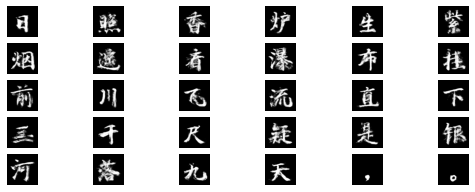

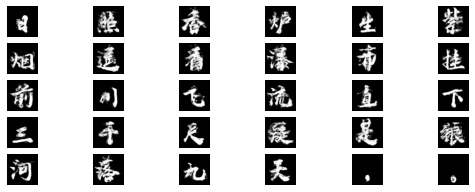

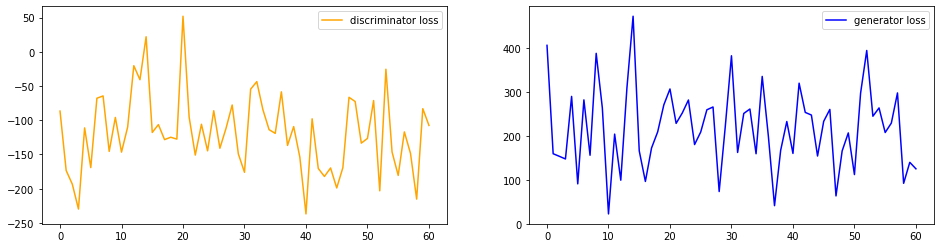

finish epoch:911 --- time use this epoch:65.51736378669739
finish epoch:912 --- time use this epoch:65.40485095977783
finish epoch:913 --- time use this epoch:64.78598165512085
finish epoch:914 --- time use this epoch:64.4970006942749
finish epoch:915 --- time use this epoch:64.17474460601807
finish epoch:916 --- time use this epoch:63.679280042648315
finish epoch:917 --- time use this epoch:64.12779903411865
finish epoch:918 --- time use this epoch:63.64772701263428
finish epoch:919 --- time use this epoch:63.85730314254761
finish epoch:920 --- time use this epoch:63.56981444358826


<Figure size 432x288 with 0 Axes>

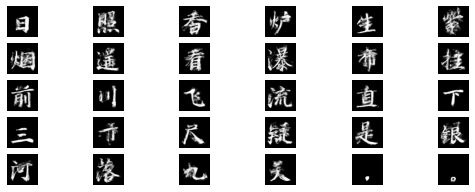

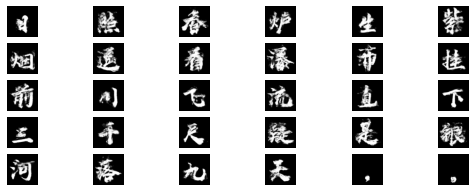

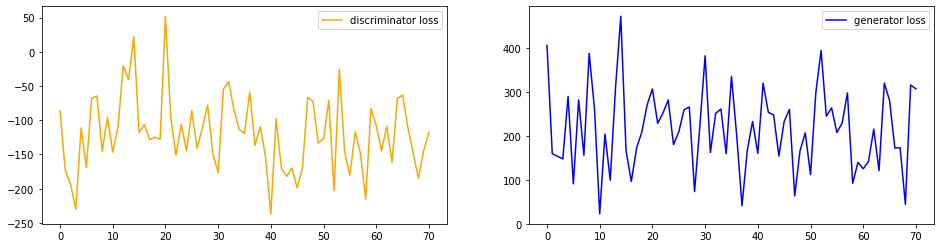

finish epoch:921 --- time use this epoch:64.08421111106873
finish epoch:922 --- time use this epoch:63.96456480026245
finish epoch:923 --- time use this epoch:63.50995111465454
finish epoch:924 --- time use this epoch:63.91441750526428
finish epoch:925 --- time use this epoch:59.49262833595276
finish epoch:926 --- time use this epoch:57.99020862579346
finish epoch:927 --- time use this epoch:57.309877157211304
finish epoch:928 --- time use this epoch:56.76185703277588
finish epoch:929 --- time use this epoch:56.12788796424866
finish epoch:930 --- time use this epoch:56.08458662033081


<Figure size 432x288 with 0 Axes>

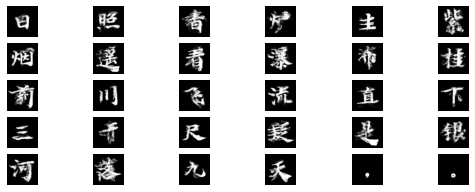

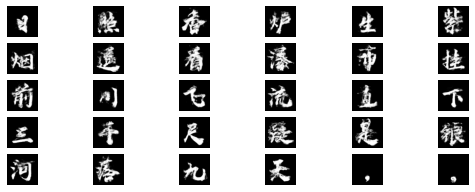

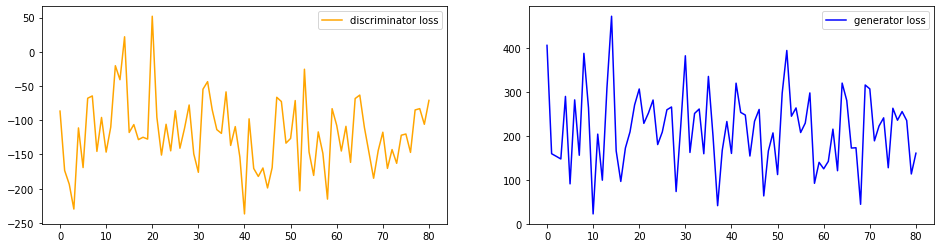

finish epoch:931 --- time use this epoch:56.397146224975586
finish epoch:932 --- time use this epoch:55.96657991409302
finish epoch:933 --- time use this epoch:55.837273359298706
finish epoch:934 --- time use this epoch:55.91288733482361
finish epoch:935 --- time use this epoch:55.78797507286072
finish epoch:936 --- time use this epoch:55.59071922302246
finish epoch:937 --- time use this epoch:55.88645315170288
finish epoch:938 --- time use this epoch:56.24267339706421
finish epoch:939 --- time use this epoch:56.05136585235596
finish epoch:940 --- time use this epoch:56.20931696891785


<Figure size 432x288 with 0 Axes>

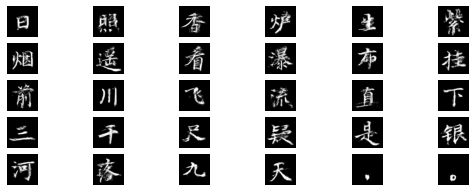

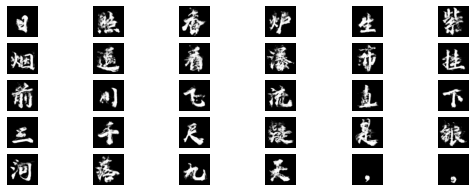

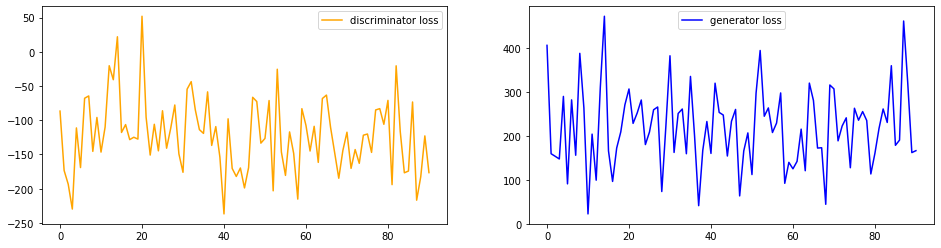

finish epoch:941 --- time use this epoch:57.049272775650024
finish epoch:942 --- time use this epoch:56.492146253585815
finish epoch:943 --- time use this epoch:56.70790362358093
finish epoch:944 --- time use this epoch:56.43631172180176
finish epoch:945 --- time use this epoch:56.65049934387207
finish epoch:946 --- time use this epoch:56.824806451797485
finish epoch:947 --- time use this epoch:56.32185173034668
finish epoch:948 --- time use this epoch:57.155988454818726
finish epoch:949 --- time use this epoch:60.530736446380615
finish epoch:950 --- time use this epoch:56.61314105987549


<Figure size 432x288 with 0 Axes>

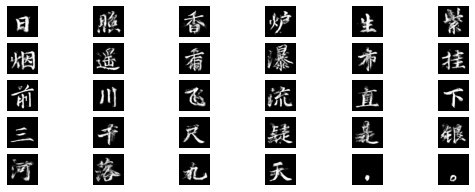

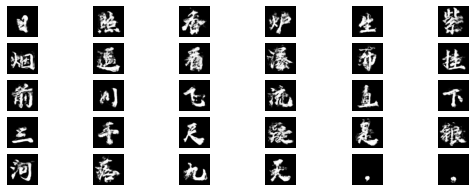

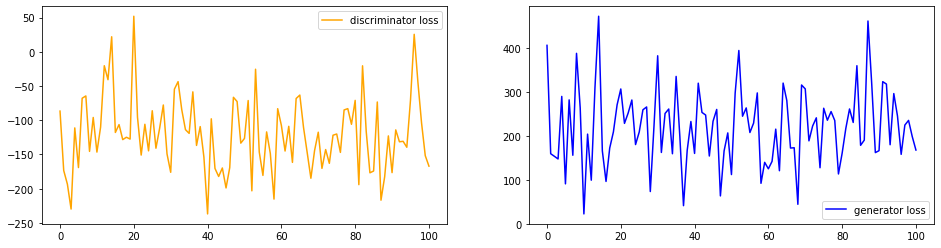

finish epoch:951 --- time use this epoch:56.80684018135071
finish epoch:952 --- time use this epoch:58.503170013427734
finish epoch:953 --- time use this epoch:59.87888741493225
finish epoch:954 --- time use this epoch:60.17118048667908
finish epoch:955 --- time use this epoch:60.064103841781616
finish epoch:956 --- time use this epoch:60.145026445388794
finish epoch:957 --- time use this epoch:59.75884485244751
finish epoch:958 --- time use this epoch:59.93021535873413
finish epoch:959 --- time use this epoch:60.40022683143616
finish epoch:960 --- time use this epoch:60.184205532073975


<Figure size 432x288 with 0 Axes>

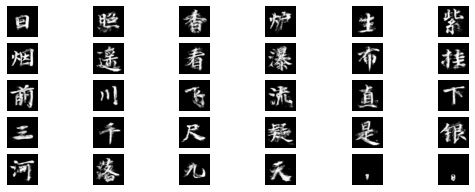

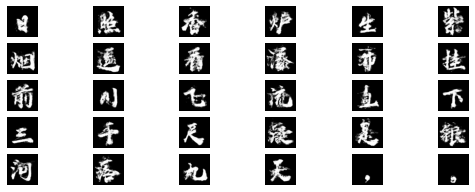

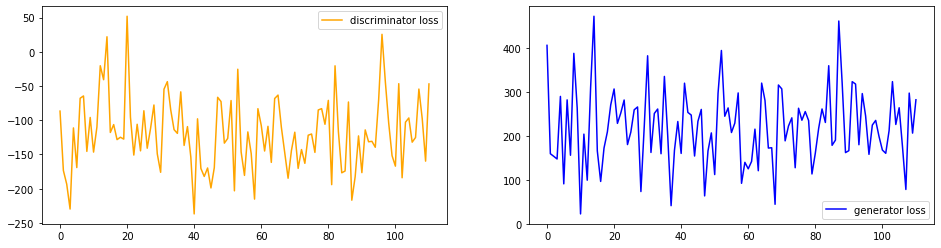

finish epoch:961 --- time use this epoch:60.65886926651001
finish epoch:962 --- time use this epoch:59.98306632041931
finish epoch:963 --- time use this epoch:60.13971257209778
finish epoch:964 --- time use this epoch:60.4786422252655
finish epoch:965 --- time use this epoch:60.346771240234375
finish epoch:966 --- time use this epoch:60.52466535568237
finish epoch:967 --- time use this epoch:62.64993214607239
finish epoch:968 --- time use this epoch:61.467883825302124
finish epoch:969 --- time use this epoch:62.20539116859436
finish epoch:970 --- time use this epoch:61.40868163108826


<Figure size 432x288 with 0 Axes>

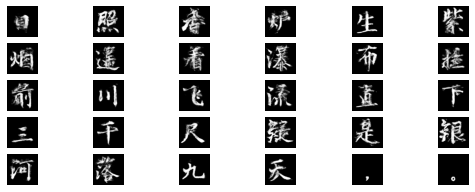

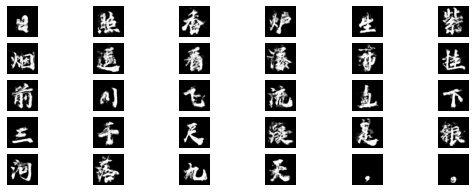

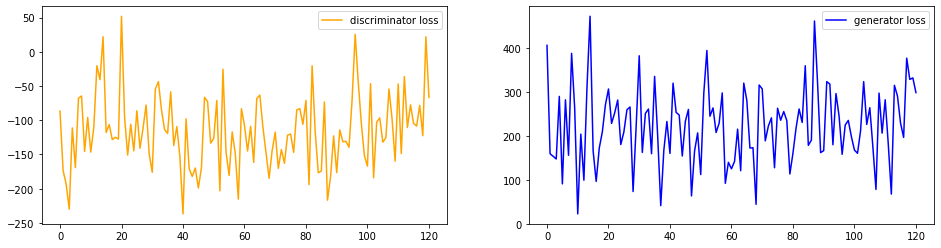

finish epoch:971 --- time use this epoch:62.01764225959778
finish epoch:972 --- time use this epoch:61.064448833465576
finish epoch:973 --- time use this epoch:61.14485812187195
finish epoch:974 --- time use this epoch:61.45626187324524
finish epoch:975 --- time use this epoch:61.32713794708252
finish epoch:976 --- time use this epoch:61.19901514053345
finish epoch:977 --- time use this epoch:61.509525775909424
finish epoch:978 --- time use this epoch:60.8453688621521
finish epoch:979 --- time use this epoch:61.19613265991211
finish epoch:980 --- time use this epoch:61.20075607299805


<Figure size 432x288 with 0 Axes>

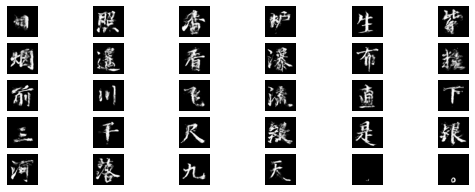

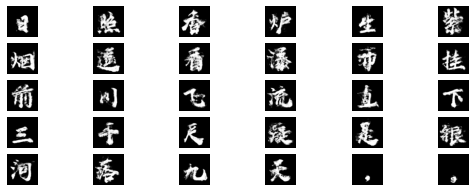

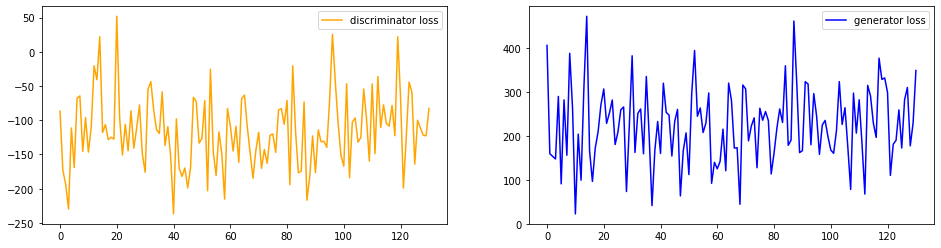

finish epoch:981 --- time use this epoch:61.83151721954346
finish epoch:982 --- time use this epoch:61.645405769348145
finish epoch:983 --- time use this epoch:61.85744571685791
finish epoch:984 --- time use this epoch:61.93384265899658
finish epoch:985 --- time use this epoch:61.85827112197876
finish epoch:986 --- time use this epoch:62.049203634262085
finish epoch:987 --- time use this epoch:61.64749622344971
finish epoch:988 --- time use this epoch:57.60617637634277
finish epoch:989 --- time use this epoch:56.77092242240906
finish epoch:990 --- time use this epoch:56.56358194351196


<Figure size 432x288 with 0 Axes>

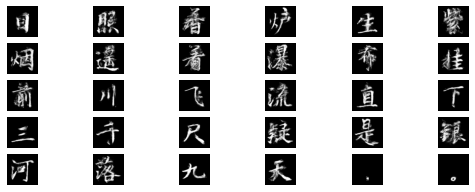

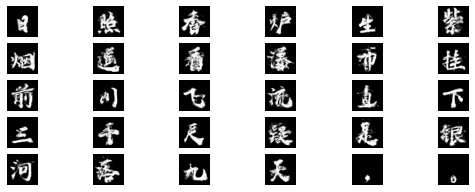

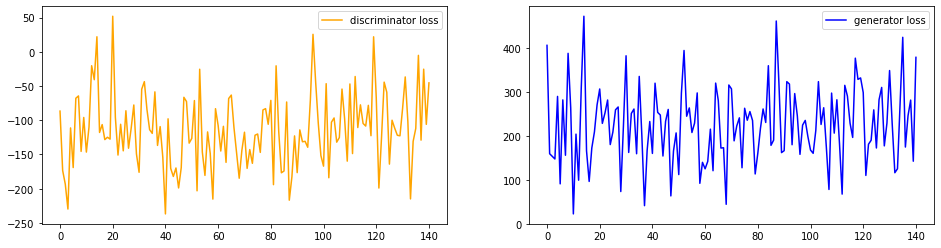

finish epoch:991 --- time use this epoch:56.564518451690674
finish epoch:992 --- time use this epoch:56.46814846992493
finish epoch:993 --- time use this epoch:57.42676854133606
finish epoch:994 --- time use this epoch:56.55128526687622
finish epoch:995 --- time use this epoch:56.06836938858032
finish epoch:996 --- time use this epoch:56.08304309844971
finish epoch:997 --- time use this epoch:56.01552867889404
finish epoch:998 --- time use this epoch:56.89966821670532
finish epoch:999 --- time use this epoch:56.16007137298584
finish epoch:1000 --- time use this epoch:56.88813352584839


<Figure size 432x288 with 0 Axes>

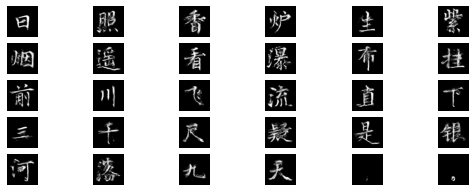

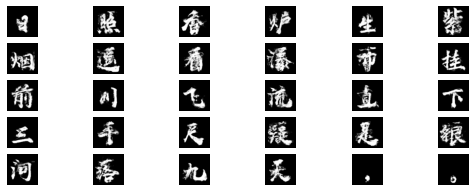

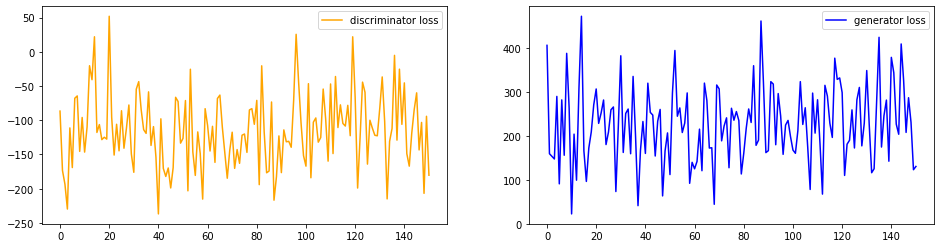

finish epoch:1001 --- time use this epoch:57.44741916656494
finish epoch:1002 --- time use this epoch:57.147178649902344
finish epoch:1003 --- time use this epoch:56.825621366500854
finish epoch:1004 --- time use this epoch:57.18487334251404
finish epoch:1005 --- time use this epoch:57.74215507507324
finish epoch:1006 --- time use this epoch:57.21036505699158
finish epoch:1007 --- time use this epoch:57.455257177352905
finish epoch:1008 --- time use this epoch:57.32541871070862
finish epoch:1009 --- time use this epoch:57.23275136947632
finish epoch:1010 --- time use this epoch:57.470993518829346


<Figure size 432x288 with 0 Axes>

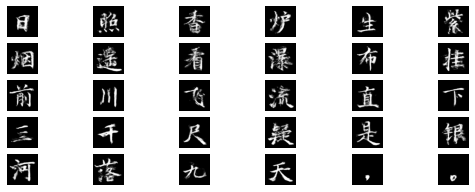

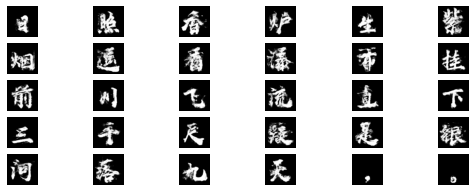

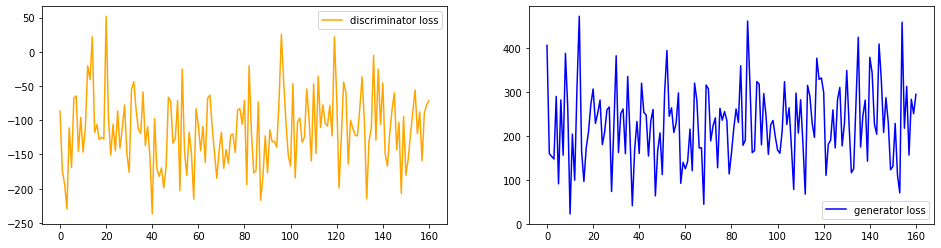

finish epoch:1011 --- time use this epoch:57.97285747528076
finish epoch:1012 --- time use this epoch:57.11988878250122
finish epoch:1013 --- time use this epoch:56.87286114692688
finish epoch:1014 --- time use this epoch:57.157490730285645
finish epoch:1015 --- time use this epoch:57.104796171188354
finish epoch:1016 --- time use this epoch:57.239269495010376
finish epoch:1017 --- time use this epoch:56.983128786087036
finish epoch:1018 --- time use this epoch:56.9384331703186
finish epoch:1019 --- time use this epoch:56.67825222015381
finish epoch:1020 --- time use this epoch:56.46761703491211


<Figure size 432x288 with 0 Axes>

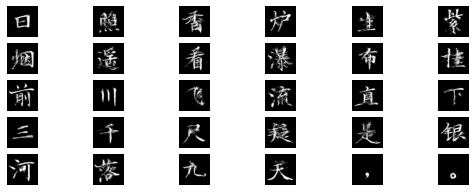

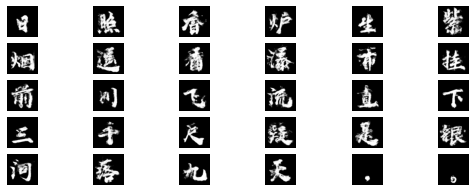

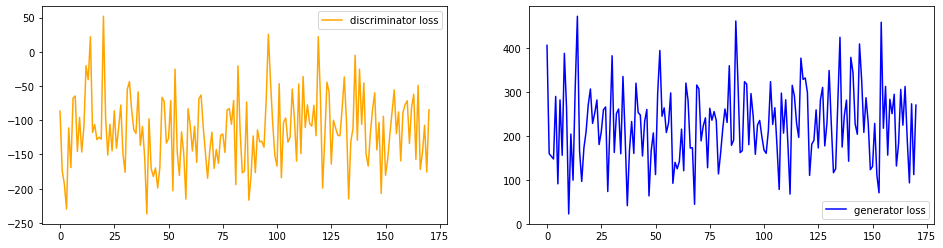

finish epoch:1021 --- time use this epoch:57.66069006919861
finish epoch:1022 --- time use this epoch:56.90168261528015
finish epoch:1023 --- time use this epoch:56.821993350982666
finish epoch:1024 --- time use this epoch:56.24657225608826
finish epoch:1025 --- time use this epoch:56.5570170879364
finish epoch:1026 --- time use this epoch:56.69741988182068
finish epoch:1027 --- time use this epoch:56.510960817337036
finish epoch:1028 --- time use this epoch:57.107895612716675
finish epoch:1029 --- time use this epoch:57.672250747680664
finish epoch:1030 --- time use this epoch:57.28593063354492


<Figure size 432x288 with 0 Axes>

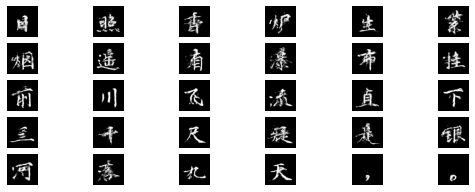

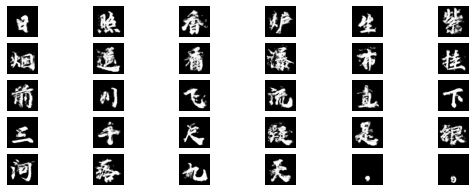

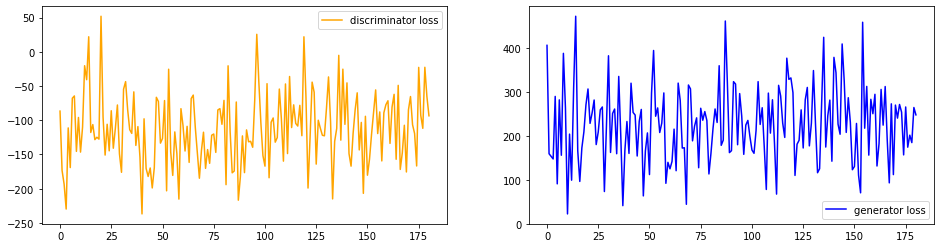

finish epoch:1031 --- time use this epoch:57.87415289878845
finish epoch:1032 --- time use this epoch:58.10935354232788
finish epoch:1033 --- time use this epoch:57.34822654724121
finish epoch:1034 --- time use this epoch:56.9728467464447
finish epoch:1035 --- time use this epoch:56.67615342140198
finish epoch:1036 --- time use this epoch:56.69269061088562
finish epoch:1037 --- time use this epoch:56.80501747131348
finish epoch:1038 --- time use this epoch:56.14546298980713
finish epoch:1039 --- time use this epoch:56.31561303138733
finish epoch:1040 --- time use this epoch:56.15405488014221


<Figure size 432x288 with 0 Axes>

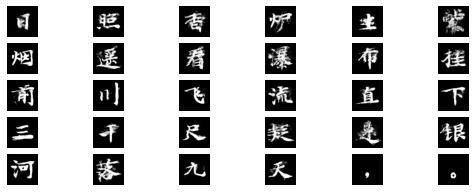

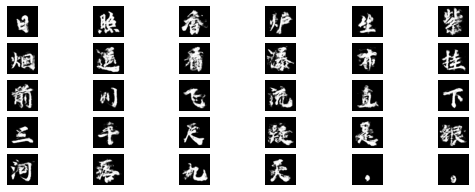

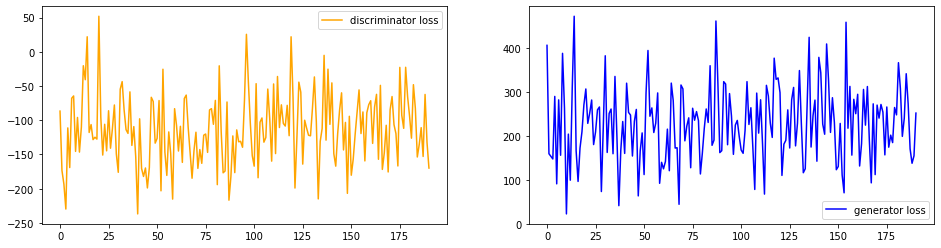

finish epoch:1041 --- time use this epoch:56.59461569786072
finish epoch:1042 --- time use this epoch:56.438437938690186
finish epoch:1043 --- time use this epoch:57.13926863670349
finish epoch:1044 --- time use this epoch:56.64501214027405
finish epoch:1045 --- time use this epoch:55.89028787612915
finish epoch:1046 --- time use this epoch:56.25380873680115
finish epoch:1047 --- time use this epoch:56.28043341636658
finish epoch:1048 --- time use this epoch:56.52313017845154
finish epoch:1049 --- time use this epoch:56.24198603630066
finish epoch:1050 --- time use this epoch:56.358468770980835


<Figure size 432x288 with 0 Axes>

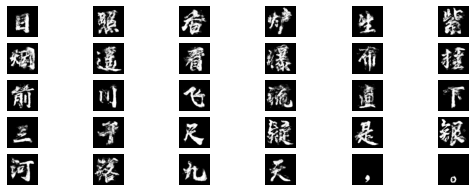

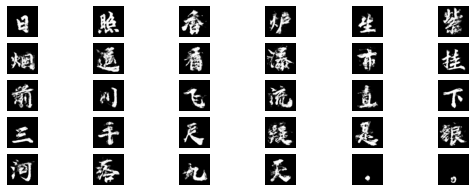

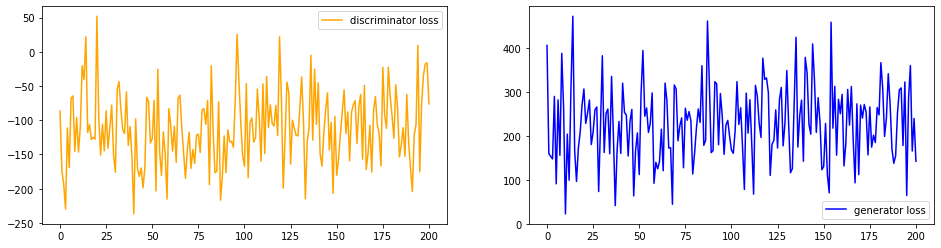

finish epoch:1051 --- time use this epoch:57.10565447807312
finish epoch:1052 --- time use this epoch:56.205787897109985
finish epoch:1053 --- time use this epoch:56.69458985328674
finish epoch:1054 --- time use this epoch:58.80458688735962
finish epoch:1055 --- time use this epoch:61.180580139160156
finish epoch:1056 --- time use this epoch:57.54412794113159
finish epoch:1057 --- time use this epoch:57.212183713912964
finish epoch:1058 --- time use this epoch:56.33174777030945
finish epoch:1059 --- time use this epoch:56.5300030708313
finish epoch:1060 --- time use this epoch:57.66370987892151


<Figure size 432x288 with 0 Axes>

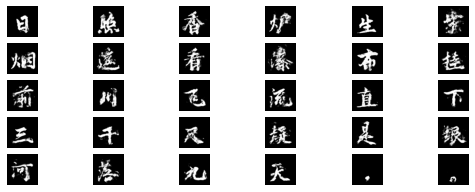

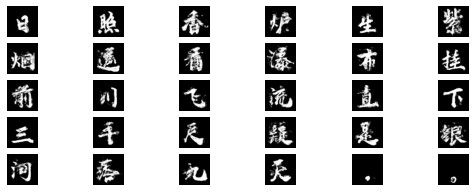

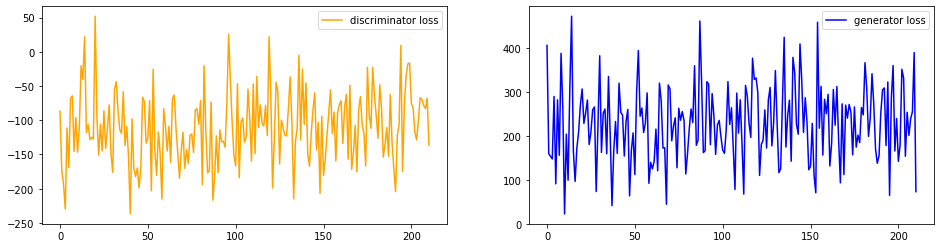

finish epoch:1061 --- time use this epoch:56.461522817611694
finish epoch:1062 --- time use this epoch:55.742037296295166
finish epoch:1063 --- time use this epoch:55.135470151901245
finish epoch:1064 --- time use this epoch:56.00302171707153
finish epoch:1065 --- time use this epoch:55.7286274433136
finish epoch:1066 --- time use this epoch:55.26574349403381
finish epoch:1067 --- time use this epoch:55.452951431274414
finish epoch:1068 --- time use this epoch:55.43364238739014
finish epoch:1069 --- time use this epoch:55.346920013427734
finish epoch:1070 --- time use this epoch:55.77192568778992


<Figure size 432x288 with 0 Axes>

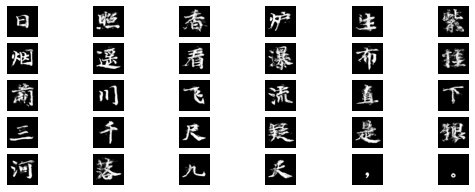

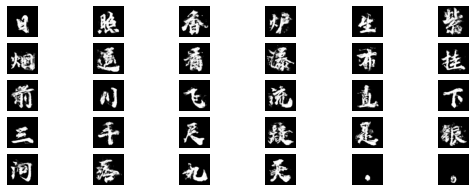

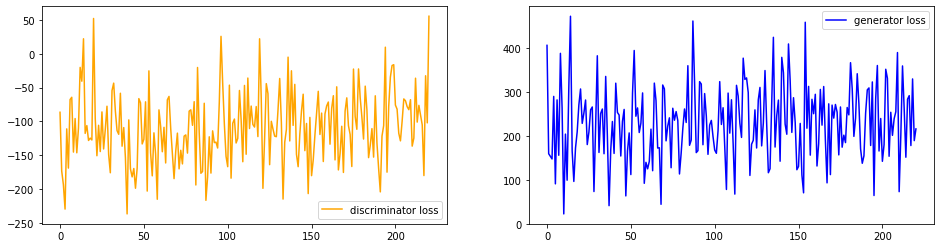

finish epoch:1071 --- time use this epoch:56.11450958251953


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
#train on font array dataset

BATCH_SIZE = 10 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
ITERS = 2500 # How many generator iterations to train for 
sample_interval = 10

gen_cost_epoch = []
disc_cost_epoch = []

for iteration in range(resume_iteration, ITERS):
    start = time.time()
    for c in range(char_number):
      data_iter = tf.data.Dataset.from_tensor_slices(data[c]).shuffle(buffer_size = 100).batch(BATCH_SIZE, drop_remainder=True).repeat()
      data_batch = iter(data_iter)
      gen_cost_c = []
      for i in range(CRITIC_ITERS):
        disc_cost_batch = []
        disc_cost_batch.append(update_disc(next(data_batch),c).numpy())
        # print('finish update c of char:{}, epoch:{}'.format(c, iteration))
      gen_cost_c.append(update_gen(c).numpy())
#       print('finish update gen of char:{}, epoch:{}'.format(c, iteration))
    gen_cost_epoch.append(np.mean(gen_cost_c))
    disc_cost_epoch.append(tf.reduce_mean(disc_cost_batch))
    print('finish epoch:{} --- time use this epoch:{}'.format(iteration, time.time() - start))
    if iteration % sample_interval == 0:
        generator.save('checkpoint_gen/cp_gen_{}th_epoch.h5'.format(iteration))
        discriminator.save('checkpoint_disc/cp_disc_{}_th_epoch.h5'.format(iteration))
        generator.save('{}cp_gen_{}th_epoch.h5'.format(google_drive_model_folder_path, iteration))
        discriminator.save('{}cp_disc_{}_th_epoch.h5'.format(google_drive_model_folder_path, iteration))
        plot_image(iteration)
        plot_same(z_fix, iteration)
        plot_loss(disc_cost_epoch, gen_cost_epoch)

# Generate Glyphs
Then we can generate glyphs using the trained model, and use the glyphs to make a composition, referencing Allison's [DCGAN notebook](https://colab.research.google.com/drive/1K5H6FqLNfUnkhkFGdFjnBuhgKEQcBldq#scrollTo=PbXROPJVCE41).

In [0]:
from PIL import ImageFont, ImageDraw, Image

In [0]:
def generate_glyphs(numchar = char_number, z = None, show_glyphs = False):
    if z == None:
      z = make_consist(num_char = numchar)
    image_sample = gen_fake_image(z)
    image_sample = image_sample.numpy().reshape(-1,img_size,img_size,1)
    if show_glyphs:
      for i in range(image_sample.shape[0]):
        plt.subplot(9, 6, i+1)
        plt.axis('off')
        plt.imshow(image_sample[i, :, :, 0], cmap = 'Greys_r')
      plt.savefig('save_img/glyphs.png')
      plt.show()
      plt.close()
    return image_sample

In [0]:
!mkdir generated_glyphs

In [0]:
def save_glyphs_png(samples):
  for i in range(samples.shape[0]):
    im_f = Image.fromarray(samples[i, :, :, 0] * 255, 'F')
    im = im_f.convert('RGB')
    im.save(f'generated_glyphs/glyph_{i}.png')

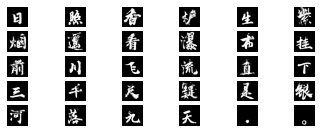

In [70]:
glyphs_random_z = generate_glyphs(show_glyphs = True)
save_glyphs_png(glyphs_random_z)

In [0]:
out_w = generator.output_shape[1]
out_h = generator.output_shape[2]

In [72]:
out_w, out_h

(128, 128)

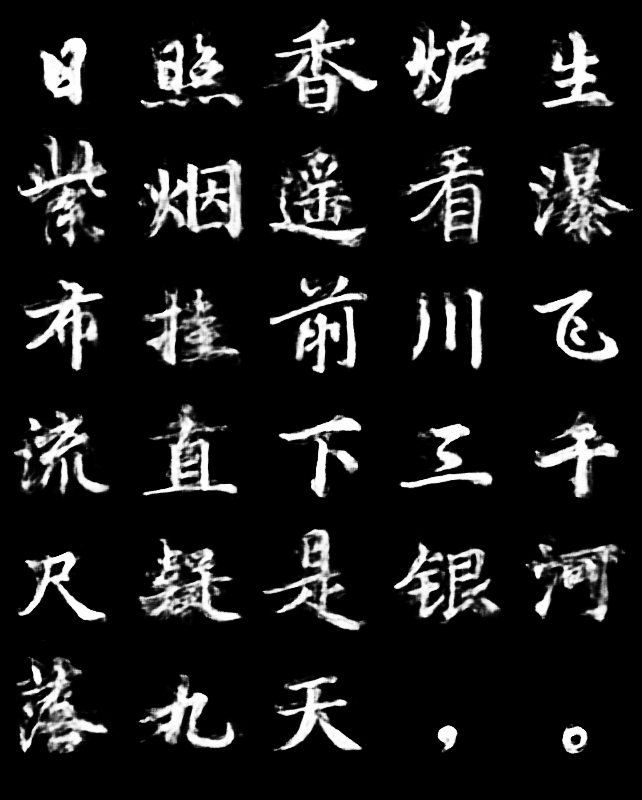

In [73]:
width = 642
height = 800
cx = 0
cy = 0
lineheight = int(out_h * 1)
page = Image.new('RGB', size=(width, height), color=(0,0,0))
# while True:
# generate glyph
# glyphs = generate_rgb(gan, np.random.randn(zdim))
glyphs = generate_glyphs(z = z_fix)
for i in range(glyphs.shape[0]):
  im_f = Image.fromarray(glyphs[i, :, :, 0] * 255, 'F')
  im = im_f.convert('RGB')
  glyph = im
  # if it would extend beyond the width of the page,
  # reset to beginning of the page and move to next
  # line
  if cx + glyph.width >= width:
      cx = 0
      cy += lineheight
  # if this position would be beyond the bottom of the page,
  # then break out of the loop
  if cy + lineheight >= height:
      break
  page.paste(glyph, (cx, cy))
  cx += glyph.width
display(page)
page.save('calligraphy.png')

# Interpolation
We can also make interpolations between different z vectors and use them to animate the composition. According to the [GlyphGAN paper](https://arxiv.org/pdf/1905.12502.pdf), z is a vector that is comprised of two parts: a character
class vector and a style vector. For the interpolation, we'll only need to interpolate the style vector. So we defined a helper function to get a z vector from a style array created using np.linspace.

In [75]:
zdim = generator.input_shape[1]

158

In [0]:
n_steps = 16
start = np.random.randn(zdim - char_number)
end = np.random.randn(zdim - char_number)
steps = np.linspace(start, end, n_steps)

In [0]:
def make_z_ndarray1d(values, num_char = char_number):
  z = tf.tile(tf.constant([values], dtype=tf.float32), [num_char,1])
  letter_one_hot = tf.reshape(tf.one_hot(0, num_char, dtype = tf.dtypes.float32), [1,-1])
  for c in range(1, num_char):
    temp = tf.reshape(tf.one_hot(c, num_char, dtype = tf.dtypes.float32), [1, -1])
    letter_one_hot = tf.concat([letter_one_hot, temp], axis = 0)
  return tf.concat([letter_one_hot,z], axis = 1)

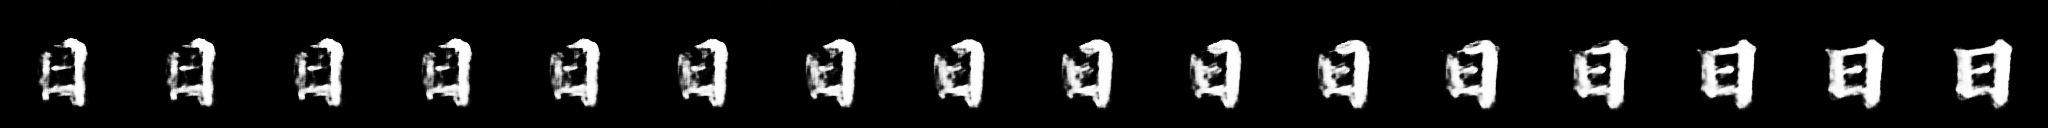

In [78]:
width = n_steps * out_w
height = out_h
page = Image.new('RGB', (width, height), (255, 255, 255))
for i in range(n_steps):
    x = i * out_w
    interp_z = make_z_ndarray1d(steps[i])
    # print(z)
    glyphs = generate_glyphs(z = interp_z)
    im_f = Image.fromarray(glyphs[0, :, :, 0] * 255, 'F')
    im = im_f.convert('RGB')
    glyph = im
    page.paste(glyph, (x, 0))
display(page)

Then we can use the interpolation results to generate a video by making each interpolated composition as a frame, and stitch  them together in ffmpeg.

In [0]:
!mkdir output

In [82]:
num_styles = 4
styles = []
n_steps = 25
c_frame = 0

start = np.random.randn(zdim - char_number)
end = np.random.randn(zdim - char_number)
start_bk = start

for i in range(num_styles):
  if i == 0:
    steps = np.linspace(start, end, n_steps)
  elif i < num_styles - 1:
    start = end
    end = np.random.randn(zdim - char_number)
    steps = np.linspace(start, end, n_steps)
  else:
    start = end
    end = start_bk
    steps = np.linspace(start, end, n_steps)
  styles.append(steps)


for i in range(len(styles)):
  steps = styles[i]
  for j in range(n_steps):
    x = i * out_w
    interp_z = make_z_ndarray1d(steps[j])
    width = 642
    height = 800
    cx = 0
    cy = 0
    lineheight = int(out_h * 1)
    page = Image.new('RGB', size=(width, height), color=(0,0,0))
    glyphs = generate_glyphs(z = interp_z)
    for k in range(glyphs.shape[0]):
      im_f = Image.fromarray(glyphs[k, :, :, 0] * 255, 'F')
      im = im_f.convert('RGB')
      glyph = im
      # if it would extend beyond the width of the page,
      # reset to beginning of the page and move to next
      # line
      if cx + glyph.width >= width:
          cx = 0
          cy += lineheight
      # if this position would be beyond the bottom of the page,
      # then break out of the loop
      if cy + lineheight >= height:
          break
      page.paste(glyph, (cx, cy))
      cx += glyph.width
      # display(page)
    print(f'style:{i}, step:{j}')
    page.save(f'output/frame{c_frame:05}.png')
    c_frame += 1

style:0, step:0
style:0, step:1
style:0, step:2
style:0, step:3
style:0, step:4
style:0, step:5
style:0, step:6
style:0, step:7
style:0, step:8
style:0, step:9
style:0, step:10
style:0, step:11
style:0, step:12
style:0, step:13
style:0, step:14
style:0, step:15
style:0, step:16
style:0, step:17
style:0, step:18
style:0, step:19
style:0, step:20
style:0, step:21
style:0, step:22
style:0, step:23
style:0, step:24
style:1, step:0
style:1, step:1
style:1, step:2
style:1, step:3
style:1, step:4
style:1, step:5
style:1, step:6
style:1, step:7
style:1, step:8
style:1, step:9
style:1, step:10
style:1, step:11
style:1, step:12
style:1, step:13
style:1, step:14
style:1, step:15
style:1, step:16
style:1, step:17
style:1, step:18
style:1, step:19
style:1, step:20
style:1, step:21
style:1, step:22
style:1, step:23
style:1, step:24
style:2, step:0
style:2, step:1
style:2, step:2
style:2, step:3
style:2, step:4
style:2, step:5
style:2, step:6
style:2, step:7
style:2, step:8
style:2, step:9
style:2, s

In [0]:
!ffmpeg -loglevel warning -y \
    -framerate 25 -f image2 -i output/frame%05d.png \
    -vcodec libx264 -crf 10 -pix_fmt yuv420p output/calligraphy.mp4

The video can be found here: https://vimeo.com/415392549